In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
cd drive/MyDrive/Dataset/


/content/drive/MyDrive/Dataset


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import fetch_openml

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics.cluster import contingency_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import paired_distances
import tensorflow as tf
from sklearn.metrics import silhouette_score 

**Dataset Information :**

- cluster originally empty
- unique id for each data point
- x point x-coordinate
- y point y-coordinate
- num neighbors number of neighbors,
- List of neighbors to the coordinates above neighbors the id&#39;s of all neighbors within

**Sample Data :**

| cluster | pt | x | y | num\_neighbors | neighbors |
| --- | --- | --- | --- | --- | --- |
|
 | 0 | 51.41808903 | 13.59361029 | 2 | 0,27 |
|
 | 1 | 39.1323184 | -4.419204415 | 3 | 1,40,75 |
|
 | 2 | 47.8075151 | -25.82256055 | 1 | 2 |
|
 | 3 | 27.69970293 | 53.43419307 | 1 | 3 |
|
 | 4 | 39.86099482 | 5.676870902 | 3 | 4,56,75 |
|
 | 5 | -19.89185932 | 10.41027381 | 3 | 5,70,74 |

In [5]:
def loadFile(filename):
  neighList = []
  pointList = []
  #  load data frame
  df = pd.read_csv(filename)
  
  # load x and y into points list

  points = df[["x", "y"]]
  
  # preprocess neighbors
  df["neighbors"] = [[int(_neigh) for _neigh in neigh_list.split(",")] for neigh_list in df["neighbors"]]
  
  # get list of neigh count and list of neigh to point

  neighs = df[["num_neighbors","neighbors"]]

  pointsList = points.to_numpy(dtype=float)
  neighsList = neighs.to_numpy(dtype=list)
  
  npArray = df.to_numpy()

  return pointsList.tolist(), neighsList.tolist(), npArray



In [7]:
def runDBScan(pointList, neighList, MinPts, epsilon):

  clusters=[]
  index = 0
  visited = set()
  noiseList = []
  # iterate over all the points until all the points assigned to cluster
  for i in range(len(pointList)) :
    # check if it is not visited
    if i not in visited:
      visited.add(i)
      # check if number of neighbours to this points greater or equals to min_pts or not
      numberOfneighs = neighList[i][0]
      neighbours = neighList[i][1]

      if numberOfneighs >= MinPts:
        # not a noise point
        # form a cluster by appending it into clusters
        clusters.append([])
        # append this points
        clusters[index].append(i)
        # form a cluster using information of neighbourhood
        createCluster(visited, neighbours, index,i,  epsilon, neighList,pointList, MinPts,clusters)
        # all the points that can be in this point's clusters are done
        #  increment index we will form new cluster now
        index+=1
      else:
        # noisy point add in noisy point list
        noiseList.append(i)

  # assign noise in seperate cluster
  # noisy cluster
  clusters.append([])
  for noise in noiseList:
    clusters[index].append(noise)

  return clusters, index


In [8]:
def createCluster (visited, currentNeighbourhood, clusterIndex, currindexPts, epsilon, neighList, pointList, MinPts, clusters) :
  for neighidx in currentNeighbourhood :
    # convert into int ( got error while processing 20ng)
    if neighidx not in visited:
      visited.add(neighidx)
      if neighList[neighidx][0] >= MinPts:
        extraNeighbours = neighList[neighidx][1]
        currentNeighbourhood+= extraNeighbours
    #  if point is already in some cluster don't assign
    isAssigned = False
    for cs in clusters:
      if neighidx in cs :
        isAssigned = True
    if isAssigned == False:
      clusters[clusterIndex].append(neighidx)



In [9]:
def getClusterPointsfromIndex(clusters,pointList):
  clusterPoints= []
  index = 0
  for cluster in clusters:
    clusterPoints.append([])
    for idx in cluster:
      clusterPoints[index].append(pointList[idx])
    index+=1
  return clusterPoints
  

In [10]:
def plotClusters(CP, title):
  for _cluster in CP:
    plt.scatter([point[0] for point in _cluster], [point[1] for point in _cluster])
    plt.title(title)
  plt.show()

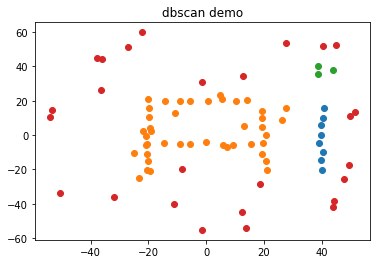

In [ ]:
#  load file
pointList, neighList, npArray = loadFile("dbscan.csv")

#  run DBScan to get clusters indexes
clusterIdx, counter = runDBScan(pointList, neighList, 3, 7.5)
# get cluster points form indexes
clusterPoints = getClusterPointsfromIndex(clusterIdx, pointList)
# plot the cluster
plotClusters(clusterPoints,"dbscan demo")

In [ ]:
def loadDataset(file):
  data = pd.read_csv(file)
  points = data.to_numpy()
  return points, data
points, data = loadDataset("circle.csv")


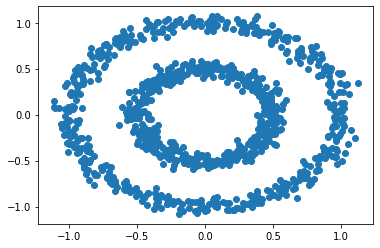

In [ ]:
# plot data set
plt.scatter([point[0] for point in points.tolist()], [point[1] for point in points.tolist()])
plt.show()

In [ ]:
# get neighbours and neighbourscount
def getNeighbours(points,epsilon , distance='euclidean'):
  neighbourhood = []
  for i in range(len(points)):
    counter = 1
    neighset = set()
    neighset.add(i)
    for j in range(len(points)):
      if i !=  j :
        if distance == 'euclidean':
          dist = np.sqrt(np.dot(points[i], points[i]) - 2 * np.dot(points[i], points[j]) + np.dot(points[j], points[j]))
        elif distance == 'cosine':
          dist = paired_distances(points[i], points[j], 'cosine')

        if (dist <= epsilon):
          counter += 1
          neighset.add(j)
          # ",".join(a_list)
    converted_list = [str(element) for element in list(neighset)]
    neighbourhood.append([counter,",".join(converted_list)])
  return neighbourhood



# neighbourHood = getNeighbours(points, .05)


In [ ]:

# data["num_neighbors"] = neighbourHood

In [ ]:
def generateDataSet(points, data, epsilon, filename, distance = 'euclidean'):
  neighbourHood = getNeighbours(points, epsilon, distance)
  neighborsDataFrame = pd.DataFrame(neighbourHood, columns=['num_neighbors','neighbors'])
  ptsSeries = pd.Series([i for i in range(len(neighbourHood))])
  cluster = pd.Series(["" for i in range(len(neighbourHood))])
  dataset = pd.DataFrame()
  data["pt"] = ptsSeries
  data["cluster"] = cluster
  data["num_neighbors"] = neighborsDataFrame["num_neighbors"]
  data["neighbors"] = neighborsDataFrame["neighbors"]
  data.columns = ["x","y","pt","cluster","num_neighbors","neighbors"]
  data.to_csv(filename, index=False)
  return data


#Circle Data Set Experiment:

In [ ]:
# db scan on Circle data set
EpsilonList = [0.02,0.05,0.1,0.5,1]
minPts = [1,2,3,4,5]
for min_pts in minPts:
  for epsilon in EpsilonList:

    circleDataset = generateDataSet(points, data, epsilon,"processedCircle.csv")

    #  load file
    circlePoints, circleNeighList, numpyData = loadFile("processedCircle.csv")

    #  run DBScan to get clusters indexes
    circleClusterIdx, counter = runDBScan(circlePoints, circleNeighList, min_pts, epsilon)
    # get cluster points form indexes
    circleClusterPoints = getClusterPointsfromIndex(circleClusterIdx, circlePoints)
    # plot the cluster
    plotClusters(circleClusterPoints, f"Circle Dataset  min_pts :{ min_pts}, epsilon : {epsilon}, numberOfCluster : {counter}")

[2, '0,87']


ZeroDivisionError: ignored

#Blob Data Set Experiment:

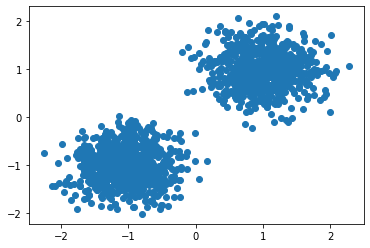

In [ ]:
blobpoints, blobdata = loadDataset("blobs.csv")
# plot row blob data points to look into data set
# plot data set
plt.scatter([point[0] for point in blobpoints.tolist()], [point[1] for point in blobpoints.tolist()])
plt.show()

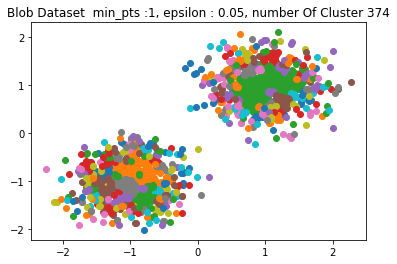

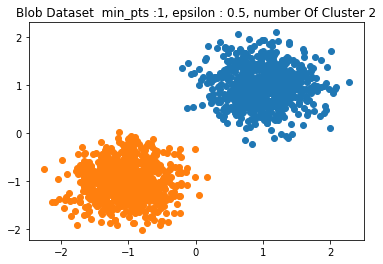

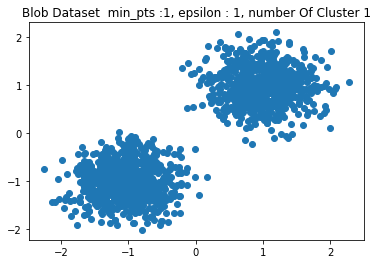

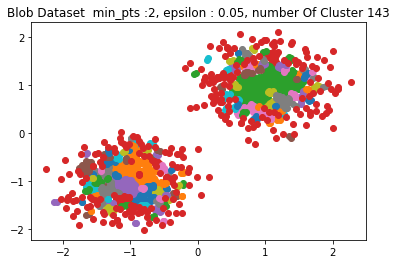

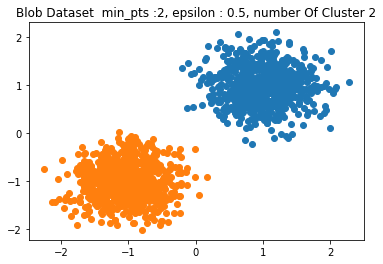

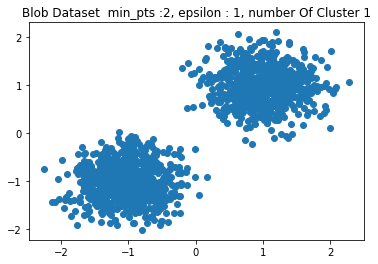

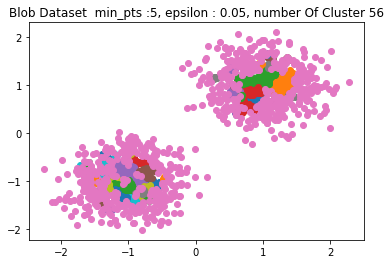

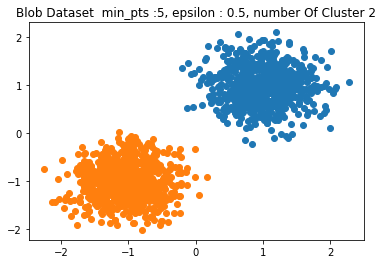

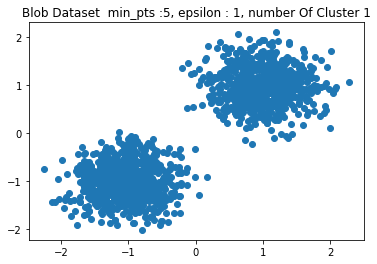

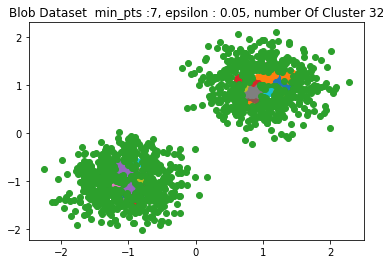

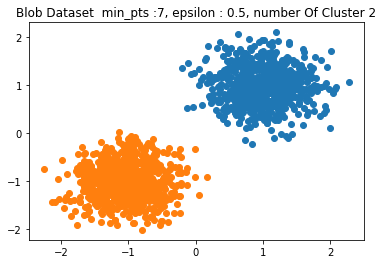

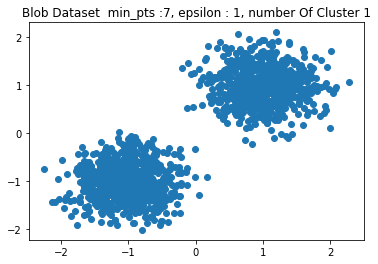

In [ ]:
# db scan on Blob data set
EpsilonList = [0.05,0.5,1]
minPts = [1,2,5,7]
for min_pts in minPts:
  for epsilon in EpsilonList:

    blobDataset = generateDataSet(blobpoints, blobdata, epsilon,"processedBlob.csv")

    #  load file
    blobPoints, blobNeighList, numpyData = loadFile("processedBlob.csv")

    #  run DBScan to get clusters indexes
    blobClusterIdx, counter = runDBScan(blobPoints, blobNeighList, min_pts, epsilon)
    # get cluster points form indexes
    blobClusterPoints = getClusterPointsfromIndex(blobClusterIdx, blobPoints)
    # plot the cluster
    plotClusters(blobClusterPoints, f"Blob Dataset  min_pts :{ min_pts}, epsilon : {epsilon}, number Of Cluster {counter}")

#Moon Data Set Experiment:

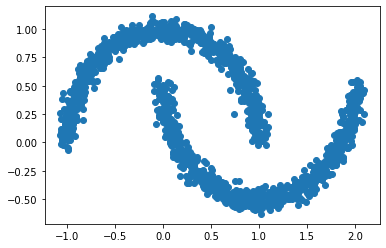

In [ ]:
moonPoints, moondata = loadDataset("moons.csv")
# plot row moon data points to look into data set
# plot data set
plt.scatter([point[0] for point in moonPoints.tolist()], [point[1] for point in moonPoints.tolist()])
plt.show()


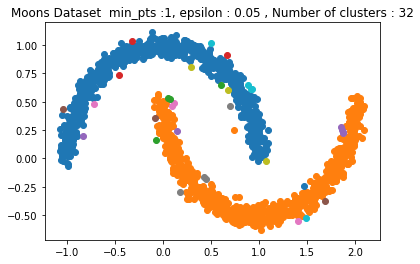

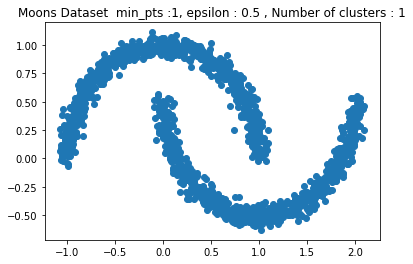

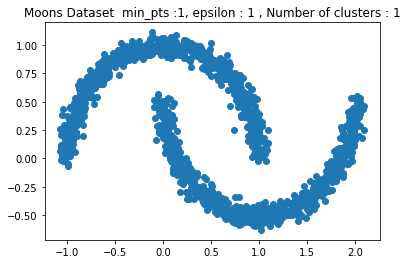

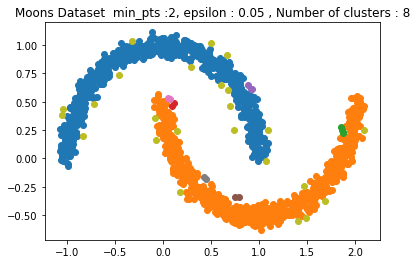

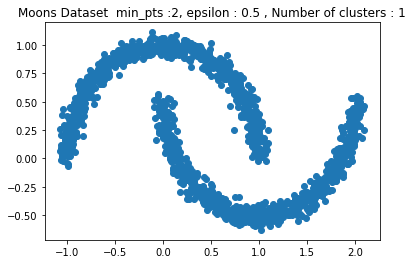

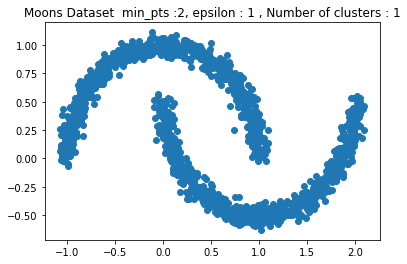

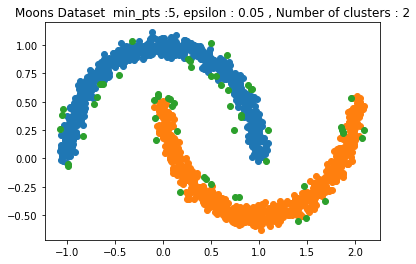

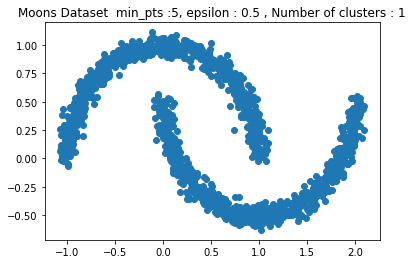

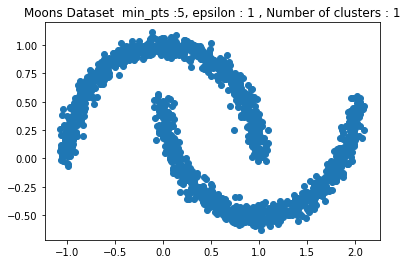

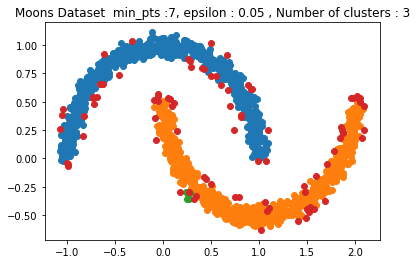

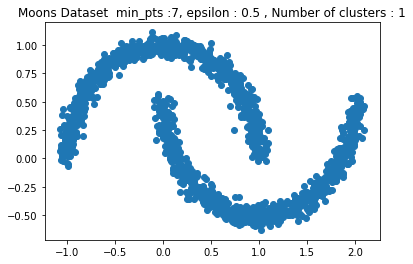

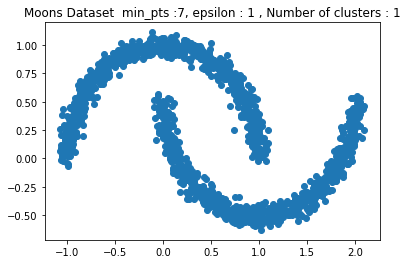

In [ ]:

# db scan on Blob data set
EpsilonList = [0.05,0.5,1]
minPts = [1,2,5,7]
for min_pts in minPts:
  for epsilon in EpsilonList:

    moonDataset = generateDataSet(moonPoints, moondata, epsilon,"processedMoons.csv")

    #  load file
    moonPoints, moonNeighList, moonNumpyData = loadFile("processedMoons.csv")

    #  run DBScan to get clusters indexes
    moonClusterIdx, counter = runDBScan(moonPoints, moonNeighList, min_pts, epsilon)
    # get cluster points form indexes
    moonClusterPoints = getClusterPointsfromIndex(moonClusterIdx, moonPoints)
    # plot the cluster
    plotClusters(moonClusterPoints, f"Moons Dataset  min_pts :{ min_pts}, epsilon : {epsilon} , Number of clusters : {counter}")

#Hierarchical Clustering :

In [ ]:
def loadMnistDigitData():
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True)  
  # Normalize the data
  # X = X/255
  return X, y

In [ ]:
X,Y = loadMnistDigitData()

In [ ]:
# np.random.choice(X.shape[0], n, replace=False) 
ids = [i for i in range(len(X))]
# randomly selec 1000 points for clustering
sampl = np.random.choice(ids, 35000, replace=False)
sampleX = np.take(X, sampl, axis=0)
sampleY = np.take(Y, sampl, axis=0)

In [ ]:
y_clusters = pd.Series(sampleY).value_counts()
clusterCount = len(y_clusters)

In [ ]:
y_clusters

1    3933
7    3644
3    3566
9    3521
0    3457
4    3441
2    3437
8    3433
6    3406
5    3162
dtype: int64

In [ ]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
sampleX = pca.fit_transform(sampleX)

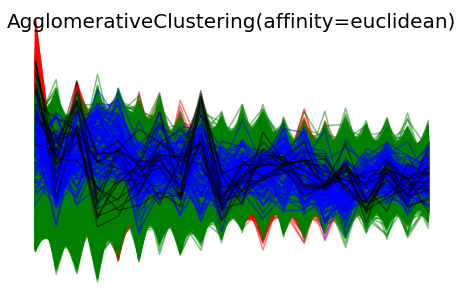

In [ ]:
# Plot clustering results
for index, metric in enumerate([ "euclidean"]):
    model = AgglomerativeClustering(linkage="average", affinity=metric, n_clusters = clusterCount)
    model.fit(sampleX)
    # print("labels", model.labels_)
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
        plt.plot(sampleX[model.labels_ == l].T, c=c, alpha=.5)
    plt.axis('tight')
    plt.axis('off')
    plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)
plt.show()

In [ ]:
y_pred =  model.labels_
len(y_pred)

35000

In [ ]:
predSeries = pd.Series(y_pred)

In [ ]:
predSeries.value_counts()

1    31457
0     3270
2      100
7       55
4       48
6       34
3       15
9       10
5        8
8        3
dtype: int64

In [12]:
def getImpurity(membership, labels):
  CM = contingency_matrix(labels, membership)
  truthCount = np.sum(np.amax(CM,axis=1))
  
  # truthCount = np.sum(np.amax(CM), axis = 0 )
  totalCount = np.sum(CM)

  purity = truthCount / totalCount 

  return purity

In [ ]:
def getGini(membership , labels) :
  CM = contingency_matrix(labels, membership)
  giniIndex = 0

  ginidensity = 0

  for _m in CM :
    total_dataPoint = np.sum(_m)
    # print("total_datapoint", total_dataPoint)
    ginidensity += total_dataPoint
    counter = 0
    for count in  _m :
      counter += pow(count/ total_dataPoint, 2)
    giniIndex += (1 - counter) * total_dataPoint
  gini_coeff = giniIndex/ ginidensity

  return gini_coeff

In [ ]:
impurity = getImpurity(y_pred, sampleY)
impurity

0.9840857142857142

In [ ]:
gini = getGini(y_pred, sampleY)
gini

0.030684752581539104

#DBSCAN on NGData

In [ ]:
data = fetch_20newsgroups( remove=('headers','footers','quotes'), random_state= 20)

In [ ]:

# Load News group data using sklearn library dataset.
  

dataset = fetch_20newsgroups(subset='all', remove=('headers','footers','quotes'), random_state= 20,shuffle=True)
data = dataset.data
labels = dataset.target
sampleData = data[:1000]
sampleLabels = labels[:1000]
vectorizer = TfidfVectorizer(stop_words='english',min_df = 5)
# # vectorize train data
ngVectorData = vectorizer.fit_transform(sampleData)
ngVectorDataDense = ngVectorData.toarray()


In [11]:
def getNeighboursLarge(points, epsilon, metric= 'euclidean'):
  points = points
  # distance = 'cosine'
  # epsilon = 0.5
  neighbourhood = []
  for i in range(len(points)):
    counter = 1
    neighset = set()
    neighset.add(i)
    for j in range(len(points)):
      if i !=  j :
        # reshaping
        
        a = points[i].reshape(1,len(points[i]))
        b = points[j].reshape(1,len(points[j]))
        dist = paired_distances(a,b, metric)
        # print(dist)
        if (dist <= epsilon):
          counter += 1
          neighset.add(j)
          # ",".join(a_list)
    # {97, 3, 68, 6, 42, 76, 46, 19, 56, 25}
    # converted_list = [str(element) for element in list(neighset)]
    neighbourhood.append([counter,list(neighset)])
  return  neighbourhood

In [ ]:
# db scan on ng20 data set
EpsilonList = [0.2,0.5,1]
minPts = [2,4,5]
# EpsilonList = [0.5]
# minPts = [2]

for min_pts in minPts:
  for epsilon in EpsilonList:
    clusterIndexPoints = []
    NGneighbourHoodList = getNeighboursLarge(ngVectorDataDense, epsilon, 'cosine')
    # print(1/0)

    #  run DBScan to get clusters indexes
    ng20ClusterIdx, counter = runDBScan(ngVectorDataDense, NGneighbourHoodList, min_pts, epsilon)
    # get cluster points form indexes
    clusterIndexPoints.append(ng20ClusterIdx)
    
    predictions = [None for i in range(len(ngVectorDataDense))]
    index = 0
    for cluster in  ng20ClusterIdx:
      for idx in cluster:
        predictions[idx] = index
      index+=1
    impurity = getImpurity(predictions,sampleLabels )
    giniIndex = getGini(predictions, sampleLabels)
    print(f"NG Data : Number of Cluster {counter}  min_pts :{ min_pts}, epsilon : {epsilon} , gini : {giniIndex}, , impurity : {impurity}")

NG Data : Number of Cluster 3  min_pts :2, epsilon : 0.2 , gini : 0.06967382089302755, , impurity : 0.963
NG Data : Number of Cluster 3  min_pts :2, epsilon : 0.5 , gini : 0.4303879630831976, , impurity : 0.681
NG Data : Number of Cluster 1  min_pts :2, epsilon : 1 , gini : 0.0, , impurity : 1.0
NG Data : Number of Cluster 1  min_pts :4, epsilon : 0.2 , gini : 0.06029477327397997, , impurity : 0.968
NG Data : Number of Cluster 1  min_pts :4, epsilon : 0.5 , gini : 0.42787958518658437, , impurity : 0.681
NG Data : Number of Cluster 1  min_pts :4, epsilon : 1 , gini : 0.0, , impurity : 1.0
NG Data : Number of Cluster 1  min_pts :5, epsilon : 0.2 , gini : 0.06029477327397997, , impurity : 0.968
NG Data : Number of Cluster 1  min_pts :5, epsilon : 0.5 , gini : 0.42961417902411936, , impurity : 0.679
NG Data : Number of Cluster 1  min_pts :5, epsilon : 1 , gini : 0.0, , impurity : 1.0


In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

  # our train data is images (28*28) we need to flatten it
  # we will do random sampling of 1000 points
ids = [i for i in range(len(train_images))]
sampl = np.random.choice(ids, 1000, replace=False)
fashion_mnist1000 = np.take(train_images, sampl, axis=0)
fashion_mnist1000Label = np.take(train_labels, sampl, axis= 0)
flatten_train_images = []
for image in fashion_mnist1000:
  flatten_train_images.append(image.flatten())
flatten_train_images =   np.array(flatten_train_images)
flatten_train_images = flatten_train_images / 255



In [ ]:
# db scan on fashion MNIST data set
EpsilonList = [2,3,4]
minPts = [5, 3, 4]
# EpsilonList = [0.5]
# minPts = [2]

for min_pts in minPts:
  for epsilon in EpsilonList:
    clusterIndexPoints = []
    NGneighbourHoodList = getNeighboursLarge(flatten_train_images, epsilon, 'euclidean')
    # print(1/0)

    #  run DBScan to get clusters indexes
    fashionMNistClusterIdx, counter = runDBScan(flatten_train_images, NGneighbourHoodList, min_pts, epsilon)
    # get cluster points form indexes
    clusterIndexPoints.append(fashionMNistClusterIdx)
    # circleClusterPoints = getClusterPointsfromIndex(circleClusterIdx, ngVectorDataDense)
    predictions = [None for i in range(len(flatten_train_images))]
    index = 0
    for cluster in  fashionMNistClusterIdx:
      for idx in cluster:
        predictions[idx] = index
      index+=1
    impurity = getImpurity(predictions,sampleLabels )
    giniIndex = getGini(predictions, sampleLabels)
    print(f"fashion MNIst Data : Number of Cluster {counter}  min_pts :{ min_pts}, epsilon : {epsilon} , gini : {giniIndex}, , impurity : {impurity}")

NG Data : Number of Cluster 0  min_pts :5, epsilon : 2 , gini : 0.0, , impurity : 1.0
NG Data : Number of Cluster 5  min_pts :5, epsilon : 3 , gini : 0.03846871963174774, , impurity : 0.98
NG Data : Number of Cluster 9  min_pts :5, epsilon : 4 , gini : 0.29091990056756856, , impurity : 0.834
NG Data : Number of Cluster 0  min_pts :3, epsilon : 2 , gini : 0.0, , impurity : 1.0
NG Data : Number of Cluster 7  min_pts :3, epsilon : 3 , gini : 0.08743961555321143, , impurity : 0.954
NG Data : Number of Cluster 20  min_pts :3, epsilon : 4 , gini : 0.40559731810162475, , impurity : 0.759
NG Data : Number of Cluster 0  min_pts :4, epsilon : 2 , gini : 0.0, , impurity : 1.0
NG Data : Number of Cluster 3  min_pts :4, epsilon : 3 , gini : 0.05160681566508707, , impurity : 0.973
NG Data : Number of Cluster 14  min_pts :4, epsilon : 4 , gini : 0.36196626061601866, , impurity : 0.788


In [ ]:
ls

 2gaussian.txt                      model2.log
 3gaussian.txt                      model.log
 blobs.csv                          model.log1
 blobs.gsheet                       model.log11
 circle.csv                         model.log.gdoc
 circle.gsheet                      moons.csv
'Convolution Layer.ipynb'           moons.gsheet
'Copy of Convolution Layer.ipynb'  'MSR-LA - 3467.docx'
 dbscan.csv                         PetImages/
 dbscan.gsheet                      processedBlob.csv
 DensityClusters.ipynb              processedCircle.csv
 dogscats.npy                       processedMoons.csv
 dogscats.txt                       proof_1b.jpeg
 Gaussian_Mixture_Models_2D.ipynb  'readme[1].txt'
 GaussianMixuerModel.ipynb          spambase.data
 kagglecatsanddogs_3367a.zip        spambase.txt
 MNIST/                             training_data.npy
 mnist.log


In [36]:
household = pd.read_csv("household_power_consumption.txt", delimiter=";",na_filter=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
household = household.dropna()

In [14]:
household.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [40]:
subsetHouseHold = household[["Global_active_power","Global_reactive_power","Voltage","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"]]

In [16]:
subsetHouseHold.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [43]:
ids = [i for i in range(len(subsetHouseHold))]
sampl = np.random.choice(ids, 1000, replace=False)
subsetHouseHold1000 = np.take(subsetHouseHold, sampl, axis=0)


In [44]:
subsetHouseHold1000 = subsetHouseHold1000.to_numpy(dtype=float)

In [55]:
# db scan on fashion MNIST data set
EpsilonList = [2,3,4]
minPts = [5, 3, 4]
# EpsilonList = [0.5]
# minPts = [2]

for min_pts in minPts:
  for epsilon in EpsilonList:
    clusterIndexPoints = []
    NGneighbourHoodList = getNeighboursLarge(subsetHouseHold1000, epsilon, 'euclidean')
    # print(1/0)

    #  run DBScan to get clusters indexes
    fashionMNistClusterIdx, counter = runDBScan(subsetHouseHold1000, NGneighbourHoodList, min_pts, epsilon)
    # get cluster points form indexes
    clusterIndexPoints.append(fashionMNistClusterIdx)
    # circleClusterPoints = getClusterPointsfromIndex(circleClusterIdx, ngVectorDataDense)
    predictions = [None for i in range(len(subsetHouseHold1000))]
    index = 0
    for cluster in  fashionMNistClusterIdx:
      for idx in cluster:
        predictions[idx] = index
      index+=1
    # impurity = getImpurity(predictions,sampleLabels )
    # giniIndex = getGini(predictions, sampleLabels)
    score  = silhouette_score(subsetHouseHold1000,predictions)
    print(f"HouseHold  Data : Number of Cluster {counter}  min_pts :{ min_pts}, epsilon : {epsilon} , silhouette_score : {score}")

HouseHold  Data : Number of Cluster 3  min_pts :5, epsilon : 2 , silhouette_score : 0.4800406950447786
HouseHold  Data : Number of Cluster 4  min_pts :5, epsilon : 3 , silhouette_score : 0.49188884469637123
HouseHold  Data : Number of Cluster 5  min_pts :5, epsilon : 4 , silhouette_score : 0.6862064745324225
HouseHold  Data : Number of Cluster 7  min_pts :3, epsilon : 2 , silhouette_score : 0.4356411510477992
HouseHold  Data : Number of Cluster 9  min_pts :3, epsilon : 3 , silhouette_score : 0.3755051811281466
HouseHold  Data : Number of Cluster 6  min_pts :3, epsilon : 4 , silhouette_score : 0.6390744221057402
HouseHold  Data : Number of Cluster 3  min_pts :4, epsilon : 2 , silhouette_score : 0.4800406950447786
HouseHold  Data : Number of Cluster 6  min_pts :4, epsilon : 3 , silhouette_score : 0.48315793873970403
HouseHold  Data : Number of Cluster 5  min_pts :4, epsilon : 4 , silhouette_score : 0.6894006340461676
